# Chapter 3: Quality Assessment

**Purpose:** Deep dive into data quality issues with actionable remediation strategies.

**What you'll learn:**
- How to analyze missing value patterns (MCAR vs MAR vs MNAR)
- How to detect and handle outliers using IQR method
- How to validate date sequences and binary fields
- How to implement data cleanup strategies

**Outputs:**
- Missing value analysis with correlation patterns
- Outlier detection with visualization
- Date logic validation results
- Binary field validation
- Cleanup code examples ready to use

---

## Quality Assessment Framework

| Issue Type | Detection Method | Common Solutions |
|------------|-----------------|------------------|
| Missing Values | Null counts, pattern analysis | Impute (mean/median/mode), drop, flag |
| Outliers | IQR, Z-score, isolation forest | Cap/clip, winsorize, transform, keep (if valid) |
| Date Logic | Sequence validation | Set placeholders to NULL, exclude invalid |
| Duplicates | Key uniqueness | Drop exact, keep most recent |
| Invalid Values | Range/domain checks | Correct, flag, exclude |

## 3.1 Setup

In [1]:
from customer_retention.analysis.auto_explorer import ExplorationFindings, RecommendationRegistry
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import ColumnType
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure

In [2]:
# === CONFIGURATION ===
# Option 1: Set the exact path from notebook 01 output
# FINDINGS_PATH = "../experiments/findings/customer_retention_retail_abc123_findings.yaml"

# Option 2: Auto-discover the most recent findings file
from pathlib import Path
import yaml

# FINDINGS_DIR imported from customer_retention.core.config.experiments

findings_files = [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name]
if not findings_files:
    raise FileNotFoundError(f"No findings files found in {FINDINGS_DIR}. Run notebook 01 first.")

# Prefer aggregated findings (from 01d) over event-level findings
# Pattern: *_aggregated* in filename indicates aggregated data
aggregated_files = [f for f in findings_files if "_aggregated" in f.name]
non_aggregated_files = [f for f in findings_files if "_aggregated" not in f.name]

if aggregated_files:
    # Use most recent aggregated file
    aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(aggregated_files[0])
    print(f"Found {len(aggregated_files)} aggregated findings file(s)")
    print(f"Using: {FINDINGS_PATH}")
    if non_aggregated_files:
        print(f"   (Skipping {len(non_aggregated_files)} event-level findings)")
else:
    # Fall back to most recent non-aggregated file
    non_aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(non_aggregated_files[0])
    print(f"Found {len(findings_files)} findings file(s)")
    print(f"Using: {FINDINGS_PATH}")

findings = ExplorationFindings.load(FINDINGS_PATH)

# Load data - handle aggregated vs standard paths
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS

# For aggregated data, load directly from the parquet source
if "_aggregated" in FINDINGS_PATH and findings.source_path.endswith('.parquet'):
    source_path = Path(findings.source_path)
    # Handle relative path from notebook directory
    if not source_path.is_absolute():
        # The source_path in findings is relative to project root
        if str(source_path).startswith("experiments"):
            source_path = Path("..") / source_path
        else:
            source_path = FINDINGS_DIR / source_path.name
    df = pd.read_parquet(source_path)
    data_source = f"aggregated:{source_path.name}"
else:
    # Standard loading for event-level or entity-level data
    df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))

print(f"Loaded data from: {data_source}")
print(f"Shape: {df.shape}")

charts = ChartBuilder()

# Load or initialize recommendation registry
RECOMMENDATIONS_PATH = FINDINGS_PATH.replace("_findings.yaml", "_recommendations.yaml")
if Path(RECOMMENDATIONS_PATH).exists():
    with open(RECOMMENDATIONS_PATH, "r") as f:
        registry = RecommendationRegistry.from_dict(yaml.safe_load(f))
    print(f"Loaded existing recommendations from: {RECOMMENDATIONS_PATH}")
else:
    registry = RecommendationRegistry()
    registry.init_bronze(findings.source_path)
    if findings.target_column:
        registry.init_gold(findings.target_column)
    entity_col = next((name for name, col in findings.columns.items() if col.inferred_type == ColumnType.IDENTIFIER), None)
    if entity_col:
        registry.init_silver(entity_col)
    print(f"Initialized new recommendation registry")

print(f"\nLoaded findings for {findings.column_count} columns")

Found 1 aggregated findings file(s)
Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml
   (Skipping 1 event-level findings)


Loaded data from: aggregated:customer_emails_408768_aggregated.parquet
Shape: (4998, 72)
Loaded existing recommendations from: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_recommendations.yaml

Loaded findings for 72 columns


## 3.2 Duplicate Analysis

**📖 Why This Matters:**
- Duplicate records can skew statistics and model training
- Key column duplicates may indicate data quality issues or event-level data
- Value conflicts (same key, different values) require investigation

**What to Watch For:**
- **Exact duplicates**: Identical rows that should be deduplicated
- **Key duplicates**: Same identifier with different values (may indicate updates or errors)
- **Value conflicts**: Same key with conflicting values in important columns

In [3]:
from customer_retention.stages.validation import DataValidator

validator = DataValidator()

# Auto-detect potential key columns
potential_keys = [name for name, col in findings.columns.items() 
                  if col.inferred_type.value in ('identifier', 'id') or 'id' in name.lower()]
KEY_COLUMN = potential_keys[0] if potential_keys else None

print("=" * 60)
print("DUPLICATE ANALYSIS")
print("=" * 60)

if KEY_COLUMN:
    dup_result = validator.check_duplicates(df, key_column=KEY_COLUMN, check_value_conflicts=True)
    print(f"\nKey Column: {KEY_COLUMN}")
    print(f"Total Rows: {dup_result.total_rows:,}")
    print(f"Unique Keys: {dup_result.unique_keys:,}")
    print(f"Duplicate Keys: {dup_result.duplicate_keys:,} ({dup_result.duplicate_percentage:.2f}%)")
    
    # Exact duplicates
    if dup_result.exact_duplicate_rows > 0:
        print(f"\n⚠️ Exact duplicate rows: {dup_result.exact_duplicate_rows:,}")
        dup_mask = df.duplicated(keep=False)
        dup_examples = df[dup_mask].head(6)
        if len(dup_examples) > 0:
            print("\nExample duplicate rows:")
            display(dup_examples)
        
        # Add deduplication recommendation for exact duplicates
        registry.add_bronze_deduplication(
            key_column=KEY_COLUMN, strategy="drop_exact_duplicates",
            rationale=f"{dup_result.exact_duplicate_rows} exact duplicate rows detected",
            source_notebook="03_quality_assessment"
        )
    else:
        print("\n✓ No exact duplicate rows")
    
    # Value conflicts
    if dup_result.has_value_conflicts:
        print(f"\n⚠️ Value conflicts detected in: {', '.join(dup_result.conflict_columns[:5])}")
        if findings.target_column and findings.target_column in dup_result.conflict_columns:
            print(f"   🔴 CRITICAL: Target '{findings.target_column}' has conflicting values!")
        
        # Show examples of conflicting records
        key_counts = df[KEY_COLUMN].value_counts()
        dup_keys = key_counts[key_counts > 1].head(3).index.tolist()
        if dup_keys:
            print("\nExample records with duplicate keys:")
            conflict_examples = df[df[KEY_COLUMN].isin(dup_keys)].sort_values(KEY_COLUMN).head(10)
            display(conflict_examples)
        
        # Add deduplication recommendation for value conflicts
        registry.add_bronze_deduplication(
            key_column=KEY_COLUMN, strategy="keep_first",
            rationale=f"Value conflicts in {len(dup_result.conflict_columns)} columns",
            source_notebook="03_quality_assessment",
            conflict_columns=dup_result.conflict_columns[:5]
        )
    else:
        print("\n✓ No value conflicts")
    
    # Duplicate frequency distribution
    if dup_result.duplicate_keys > 0:
        key_counts = df[KEY_COLUMN].value_counts()
        dup_distribution = key_counts[key_counts > 1].value_counts().sort_index()
        if len(dup_distribution) > 0:
            print("\nDuplicate frequency distribution:")
            for count, num_keys in dup_distribution.head(5).items():
                print(f"   Keys appearing {count}x: {num_keys:,}")
        
        # Recommendations
        print("\n💡 RECOMMENDATIONS:")
        if dup_result.exact_duplicate_rows > 0:
            print("   • Remove exact duplicates: df.drop_duplicates()")
        if dup_result.has_value_conflicts:
            print("   • For value conflicts, decide strategy:")
            print("     - Keep most recent (if you have a timestamp)")
            print("     - Keep first occurrence: df.drop_duplicates(subset=[KEY_COLUMN], keep='first')")
            print("     - Aggregate values (for numeric columns)")
else:
    print("\n⚠️ No key column detected.")
    print("   Set KEY_COLUMN above to enable duplicate analysis.")
    print(f"   Available columns: {list(findings.columns.keys())[:10]}...")

DUPLICATE ANALYSIS

Key Column: customer_id
Total Rows: 4,998
Unique Keys: 4,998
Duplicate Keys: 0 (0.00%)

✓ No exact duplicate rows

✓ No value conflicts


## 3.3 Overall Quality Score

In [4]:
print(f"Overall Quality Score: {findings.overall_quality_score:.1f}/100")

if findings.overall_quality_score >= 90:
    print("Excellent: Data is high quality and ready for modeling.")
elif findings.overall_quality_score >= 70:
    print("Good: Minor quality issues that should be addressed.")
elif findings.overall_quality_score >= 50:
    print("Fair: Significant quality issues require attention.")
else:
    print("Poor: Major quality issues must be resolved before modeling.")

Overall Quality Score: 89.0/100
Good: Minor quality issues that should be addressed.


## 3.4 Target Variable Analysis

Understanding target distribution is critical for:
- **Class imbalance** affects model training and evaluation metrics
- **Business context** helps interpret what we're trying to predict
- **Sampling strategies** depend on imbalance severity

TARGET VARIABLE DISTRIBUTION: target


,target,count,percentage
0,0,3034,60.704
1,1,1964,39.296



Imbalance ratio: 1.54:1 (minority class: 1)
Retention rate: 39.3%

⚠️ Business Context: 39% retention is concerning!
   High churn rate requires urgent attention.

⚠️  Class imbalance considerations for modeling:
   - Use stratified sampling for train/test splits
   - Consider class weights in model training
   - Evaluate with Precision-Recall AUC (not just ROC-AUC)
   - Focus on recall for churned class (catch at-risk customers)
   - SMOTE not needed (imbalance is mild)


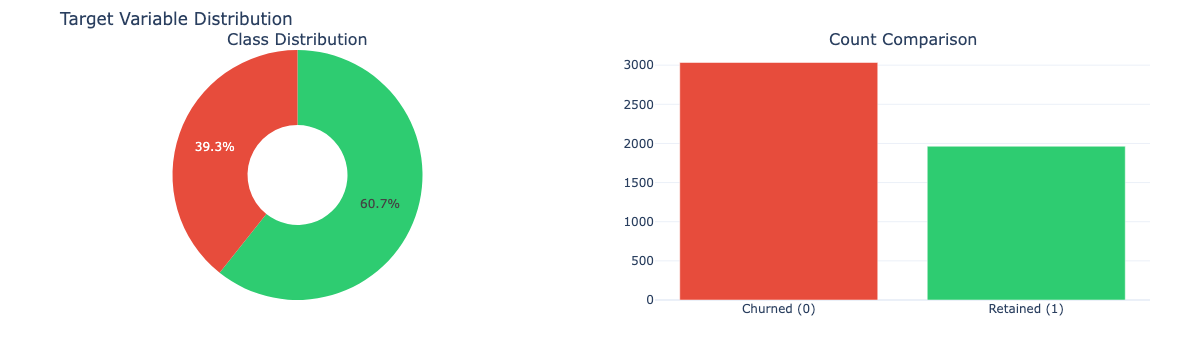

In [5]:
print("=" * 60)
print(f"TARGET VARIABLE DISTRIBUTION: {findings.target_column}")
print("=" * 60)

if findings.target_column and findings.target_column in df.columns:
    target_series = df[findings.target_column]
    target_counts = target_series.value_counts().sort_index()
    
    # Create distribution table
    dist_data = []
    for val, count in target_counts.items():
        pct = count / len(df) * 100
        dist_data.append({
            findings.target_column: val,
            "count": count,
            "percentage": f"{pct:.3f}"
        })
    
    dist_df = pd.DataFrame(dist_data)
    display(dist_df)
    
    # Calculate imbalance metrics
    if len(target_counts) == 2:
        majority = target_counts.max()
        minority = target_counts.min()
        minority_class = target_counts.idxmin()
        imbalance_ratio = majority / minority
        retention_rate = target_counts.get(1, 0) / len(df) * 100
        
        print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1 (minority class: {minority_class})")
        print(f"Retention rate: {retention_rate:.1f}%")
        
        # Business context
        if retention_rate > 70:
            print(f"\n📊 Business Context: {retention_rate:.0f}% retention is healthy!")
            print("   Churned customers are the minority class we want to predict.")
        elif retention_rate > 50:
            print(f"\n📊 Business Context: {retention_rate:.0f}% retention is moderate.")
            print("   Balanced focus on both retention and churn prediction.")
        else:
            print(f"\n⚠️ Business Context: {retention_rate:.0f}% retention is concerning!")
            print("   High churn rate requires urgent attention.")
        
        # Modeling recommendations based on imbalance
        print("\n⚠️  Class imbalance considerations for modeling:")
        print("   - Use stratified sampling for train/test splits")
        print("   - Consider class weights in model training")
        print("   - Evaluate with Precision-Recall AUC (not just ROC-AUC)")
        print("   - Focus on recall for churned class (catch at-risk customers)")
        
        # Add imbalance strategy recommendation
        if imbalance_ratio < 3:
            strategy = "stratified_sampling"
            rationale = f"Mild imbalance ({imbalance_ratio:.2f}:1) - stratified sampling sufficient"
            print("   - SMOTE not needed (imbalance is mild)")
        elif imbalance_ratio < 5:
            strategy = "class_weights"
            rationale = f"Moderate imbalance ({imbalance_ratio:.2f}:1) - use class weights"
            print("   - SMOTE may not be necessary (imbalance is moderate)")
        else:
            strategy = "smote"
            rationale = f"Severe imbalance ({imbalance_ratio:.2f}:1) - consider SMOTE"
            print("   - Consider SMOTE or undersampling (imbalance is severe)")
        
        registry.add_bronze_imbalance_strategy(
            target_column=findings.target_column,
            imbalance_ratio=imbalance_ratio,
            minority_class=minority_class,
            strategy=strategy,
            rationale=rationale,
            source_notebook="03_quality_assessment"
        )
        
        # Visualization
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]],
                           subplot_titles=["Class Distribution", "Count Comparison"])
        
        labels = [f"{'Retained' if v == 1 else 'Churned'} ({v})" for v in target_counts.index]
        fig.add_trace(go.Pie(labels=labels, values=target_counts.values, hole=0.4,
                            marker_colors=["#2ecc71", "#e74c3c"]), row=1, col=1)
        fig.add_trace(go.Bar(x=labels, y=target_counts.values,
                            marker_color=["#e74c3c", "#2ecc71"]), row=1, col=2)
        
        fig.update_layout(height=350, title_text="Target Variable Distribution",
                         showlegend=False, template="plotly_white")
        display_figure(fig)
    else:
        print(f"\nMulticlass target with {len(target_counts)} classes")
        
        fig = go.Figure(go.Bar(x=[str(v) for v in target_counts.index], y=target_counts.values,
                               marker_color=px.colors.qualitative.Set2[:len(target_counts)]))
        fig.update_layout(height=350, title_text="Target Variable Distribution",
                         xaxis_title=findings.target_column, yaxis_title="Count",
                         template="plotly_white")
        display_figure(fig)
else:
    print("\n⚠️ No target column detected or specified.")
    print("   Set target_hint parameter in DataExplorer.explore() or")
    print("   manually specify in findings.target_column")

## 3.5 Missing Value Analysis

**📖 Interpretation Guide:**
- **MCAR (Missing Completely at Random)**: Missing values have no pattern - safe to impute with mean/median
- **MAR (Missing at Random)**: Missingness depends on other observed variables - use regression imputation
- **MNAR (Missing Not at Random)**: Missingness depends on the missing value itself - create missing indicator

**⚠️ What to Watch For:**
- Columns with >50% missing may need to be dropped
- Highly correlated missing patterns suggest MAR
- ID columns with missing values indicate data integrity issues

Columns with Missing Values:


,Column,Missing Count,Missing %
8,time_to_open_hours_mean_180d,4314,86.31%
9,time_to_open_hours_max_180d,4314,86.31%
19,time_to_open_hours_max_365d,3757,75.17%
18,time_to_open_hours_mean_365d,3757,75.17%
0,opened_mean_180d,2884,57.70%
2,clicked_mean_180d,2884,57.70%
3,clicked_max_180d,2884,57.70%
4,send_hour_mean_180d,2884,57.70%
5,send_hour_max_180d,2884,57.70%
6,bounced_mean_180d,2884,57.70%


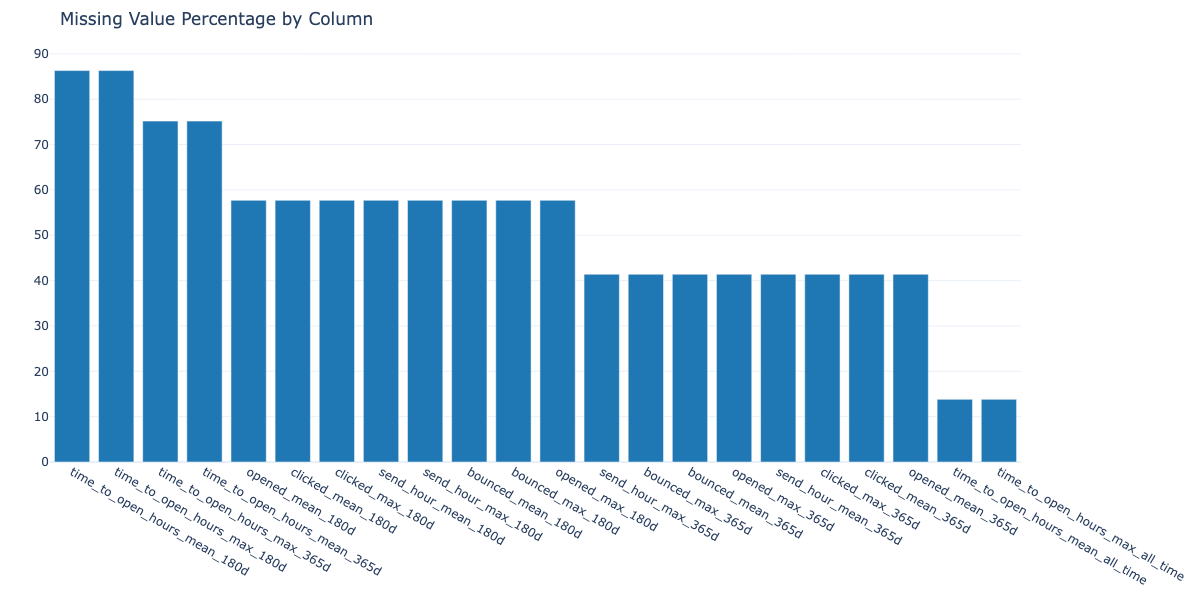

In [6]:
missing_data = []
for col_name, col_info in findings.columns.items():
    null_count = col_info.universal_metrics.get("null_count", 0)
    null_pct = col_info.universal_metrics.get("null_percentage", 0)
    if null_count > 0:
        missing_data.append({
            "Column": col_name,
            "Missing Count": null_count,
            "Missing %": f"{null_pct:.2f}%"
        })

if missing_data:
    missing_df = pd.DataFrame(missing_data).sort_values("Missing Count", ascending=False)
    print("Columns with Missing Values:")
    display(missing_df)
    
    fig = charts.bar_chart(
        missing_df["Column"].tolist(),
        [float(x.replace("%", "")) for x in missing_df["Missing %"].tolist()],
        title="Missing Value Percentage by Column"
    )
    display_figure(fig)
else:
    print("No missing values detected.")

## 3.6 Missing Value Patterns

**📖 How to Read the Correlation Heatmap:**
- **Correlation = 1.0**: Columns always missing together (same rows)
- **Correlation > 0.5**: Strong pattern - investigate the relationship
- **Correlation ≈ 0**: Independent missing patterns (MCAR likely)

Missing Value Correlations (MCAR vs MAR analysis):


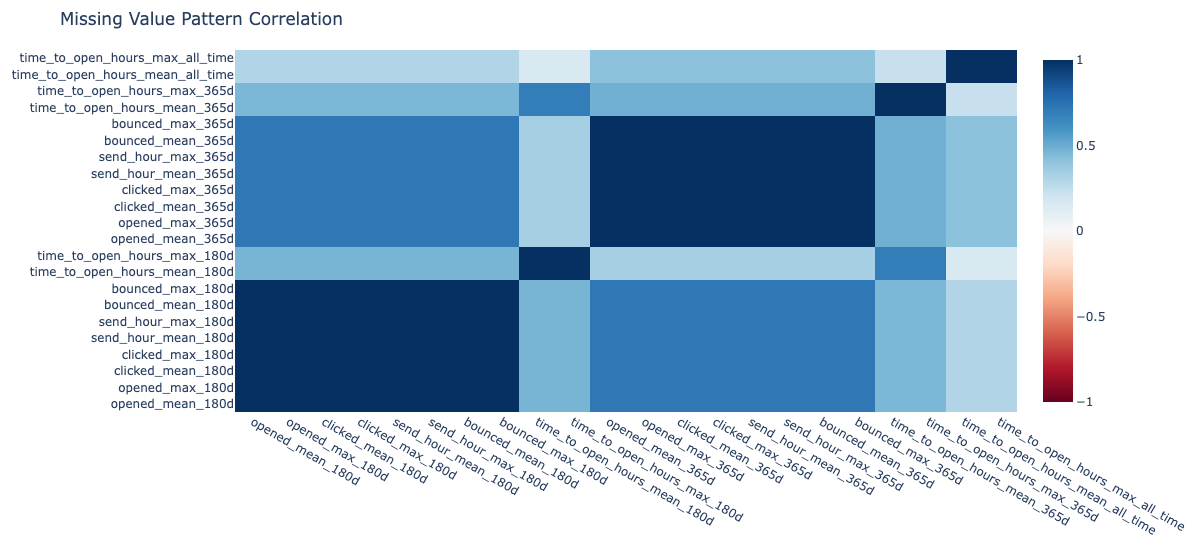

In [7]:
missing_matrix = df.isnull()
missing_correlations = missing_matrix.corr()

cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
if len(cols_with_missing) > 1:
    print("Missing Value Correlations (MCAR vs MAR analysis):")
    fig = charts.heatmap(
        missing_correlations.loc[cols_with_missing, cols_with_missing].values,
        x_labels=cols_with_missing,
        y_labels=cols_with_missing,
        title="Missing Value Pattern Correlation"
    )
    display_figure(fig)

## 3.7 Segment-Aware Outlier Analysis

**📖 Why Segment Before Detecting Outliers?**

Global outlier detection can produce **false positives** when data contains natural segments:
- **Retail vs Enterprise customers**: Order values of $5K may be outliers for retail but normal for enterprise
- **New vs Established accounts**: Activity patterns differ dramatically by customer tenure
- **Geographic segments**: Regional price differences can appear as outliers globally

**⚠️ The Risk:**
If you remove "outliers" that are actually valid data from a different segment, you lose critical patterns needed for accurate modeling.

**📊 What This Analysis Does:**
1. Detects natural data segments (using clustering or explicit segment columns)
2. Compares global outliers vs segment-specific outliers
3. Identifies "false outliers" - values flagged globally but normal within their segment
4. Recommends whether segment-specific outlier treatment is beneficial

In [8]:
from customer_retention.stages.profiling import SegmentAwareOutlierAnalyzer

print("=" * 80)
print("SEGMENT-AWARE OUTLIER ANALYSIS")
print("=" * 80)

# Get numeric columns for analysis
numeric_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
    and name not in TEMPORAL_METADATA_COLS
]

# === CONFIGURATION ===
# Option 1: Specify an explicit segment column if you have one (e.g., customer_type, region)
SEGMENT_COL = None  # e.g., "customer_segment", "account_type"

# Option 2: Load from findings metadata if saved in previous notebook
if SEGMENT_COL is None and "segment_column" in findings.metadata:
    SEGMENT_COL = findings.metadata["segment_column"]
    print(f"Using segment column from findings: {SEGMENT_COL}")

if numeric_cols:
    analyzer = SegmentAwareOutlierAnalyzer(max_segments=5)
    
    # Run segment-aware analysis
    segment_result = analyzer.analyze(
        df,
        feature_cols=numeric_cols,
        segment_col=SEGMENT_COL,
        target_col=findings.target_column
    )
    
    print(f"\n📊 SEGMENTATION RESULTS:")
    print(f"   Segments detected: {segment_result.n_segments}")
    
    if segment_result.n_segments > 1:
        print(f"\n📈 GLOBAL VS SEGMENT OUTLIER COMPARISON:")
        print("-" * 60)
        
        comparison_data = []
        for col in numeric_cols:
            global_outliers = segment_result.global_analysis[col].outliers_detected
            segment_outliers = sum(
                seg[col].outliers_detected 
                for seg in segment_result.segment_analysis.values()
                if col in seg
            )
            false_outliers = segment_result.false_outliers.get(col, 0)
            
            if global_outliers > 0:
                reduction_pct = (global_outliers - segment_outliers) / global_outliers * 100
                false_pct = false_outliers / global_outliers * 100
            else:
                reduction_pct = 0
                false_pct = 0
            
            comparison_data.append({
                "Feature": col,
                "Global Outliers": global_outliers,
                "Segment Outliers": segment_outliers,
                "False Outliers": false_outliers,
                "Reduction": f"{reduction_pct:.1f}%"
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        display(comparison_df)
        
        # Show false outlier analysis
        has_false_outliers = any(segment_result.false_outliers.get(col, 0) > 0 for col in numeric_cols)
        
        if has_false_outliers:
            print("\n⚠️ FALSE OUTLIERS DETECTED:")
            print("   (Global outliers that are normal within their segment)")
            for col, count in segment_result.false_outliers.items():
                if count > 0:
                    global_count = segment_result.global_analysis[col].outliers_detected
                    pct = count / global_count * 100 if global_count > 0 else 0
                    print(f"   • {col}: {count} false outliers ({pct:.1f}% of global)")
        
        # Recommendations
        print("\n💡 RECOMMENDATIONS:")
        if segment_result.segmentation_recommended:
            print("   ✅ SEGMENT-SPECIFIC OUTLIER TREATMENT RECOMMENDED")
            for rec in segment_result.recommendations:
                print(f"      • {rec}")
            
            # Add outlier recommendations for columns with high false outlier rate
            for col, count in segment_result.false_outliers.items():
                if count > 0:
                    global_count = segment_result.global_analysis[col].outliers_detected
                    false_pct = count / global_count * 100 if global_count > 0 else 0
                    if false_pct > 50:  # High false outlier rate
                        registry.add_bronze_outlier(
                            column=col, action="segment_aware_cap",
                            parameters={"method": "segment_iqr", "n_segments": segment_result.n_segments},
                            rationale=f"{false_pct:.0f}% of global outliers are segment-normal",
                            source_notebook="03_quality_assessment"
                        )
        else:
            print("   ℹ️ Global outlier treatment is appropriate for this data")
        
        # Rationale
        print("\n📋 RATIONALE:")
        for rationale in segment_result.rationale:
            print(f"   • {rationale}")
        
        # Visualization: Compare outlier counts
        cols_with_diff = [
            row["Feature"] for _, row in comparison_df.iterrows()
            if row["Global Outliers"] > 0 and row["Global Outliers"] != row["Segment Outliers"]
        ]
        
        if cols_with_diff and len(cols_with_diff) <= 8:
            fig = go.Figure()
            
            global_counts = [comparison_df[comparison_df["Feature"] == c]["Global Outliers"].values[0] for c in cols_with_diff]
            segment_counts = [comparison_df[comparison_df["Feature"] == c]["Segment Outliers"].values[0] for c in cols_with_diff]
            
            fig.add_trace(go.Bar(name="Global Outliers", x=cols_with_diff, y=global_counts, marker_color="#e74c3c"))
            fig.add_trace(go.Bar(name="Segment Outliers", x=cols_with_diff, y=segment_counts, marker_color="#2ecc71"))
            
            fig.update_layout(
                barmode="group",
                title="Global vs Segment-Specific Outlier Detection",
                xaxis_title="Feature",
                yaxis_title="Outlier Count",
                template="plotly_white",
                height=400
            )
            display_figure(fig)
    else:
        print("\n   ℹ️ Data appears homogeneous (single segment)")
        print("   → Proceeding with standard global outlier detection")
    
    # Store result in findings metadata for use in later notebooks
    findings.metadata["segment_aware_analysis"] = {
        "n_segments": segment_result.n_segments,
        "segmentation_recommended": segment_result.segmentation_recommended,
        "recommendations": segment_result.recommendations
    }
else:
    print("\nNo numeric columns to analyze for outliers.")

SEGMENT-AWARE OUTLIER ANALYSIS



📊 SEGMENTATION RESULTS:
   Segments detected: 2

📈 GLOBAL VS SEGMENT OUTLIER COMPARISON:
------------------------------------------------------------


,Feature,Global Outliers,Segment Outliers,False Outliers,Reduction
0,event_count_180d,298,24,152,91.9%
1,event_count_365d,112,50,49,55.4%
2,event_count_all_time,298,39,51,86.9%
3,opened_sum_180d,684,47,637,93.1%
4,opened_mean_180d,0,5,0,0.0%
5,opened_count_180d,298,24,152,91.9%
6,clicked_sum_180d,237,1,236,99.6%
7,clicked_mean_180d,237,1,236,99.6%
8,clicked_count_180d,298,24,152,91.9%
9,send_hour_sum_180d,200,7,119,96.5%



⚠️ FALSE OUTLIERS DETECTED:
   (Global outliers that are normal within their segment)
   • event_count_180d: 152 false outliers (51.0% of global)
   • event_count_365d: 49 false outliers (43.8% of global)
   • event_count_all_time: 51 false outliers (17.1% of global)
   • opened_sum_180d: 637 false outliers (93.1% of global)
   • opened_count_180d: 152 false outliers (51.0% of global)
   • clicked_sum_180d: 236 false outliers (99.6% of global)
   • clicked_mean_180d: 236 false outliers (99.6% of global)
   • clicked_count_180d: 152 false outliers (51.0% of global)
   • send_hour_sum_180d: 119 false outliers (59.5% of global)
   • send_hour_count_180d: 152 false outliers (51.0% of global)
   • bounced_count_180d: 152 false outliers (51.0% of global)
   • time_to_open_hours_sum_180d: 647 false outliers (95.4% of global)
   • time_to_open_hours_max_180d: 3 false outliers (11.1% of global)
   • time_to_open_hours_count_180d: 637 false outliers (93.1% of global)
   • opened_sum_365d: 680 f

## 3.8 Global Outlier Detection

**📖 IQR Method Explained:**
- **Q1** = 25th percentile, **Q3** = 75th percentile
- **IQR** = Q3 - Q1 (the middle 50% of data)
- **Lower Bound** = Q1 - 1.5 × IQR
- **Upper Bound** = Q3 + 1.5 × IQR
- Values outside these bounds are considered outliers

**⚠️ Important Considerations:**
- Review section 3.7 above to determine if global or segment-specific outlier treatment is appropriate
- Outliers in rate fields (>100%) are likely errors → Cap at 100
- Outliers in amount fields may be valid high-value customers → Keep but consider capping for modeling
- High outlier % (>10%) suggests heavy-tailed distribution → Consider log transform instead of capping

In [9]:
print("=" * 80)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 80)

numeric_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
    and name not in TEMPORAL_METADATA_COLS
]

# Build comprehensive outlier table
outlier_data = []
for col_name in numeric_cols:
    series = df[col_name].dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers_low = (series < lower_bound).sum()
    outliers_high = (series > upper_bound).sum()
    total_outliers = outliers_low + outliers_high
    
    outlier_data.append({
        "feature": col_name,
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outliers_low": outliers_low,
        "outliers_high": outliers_high,
        "total_outliers": total_outliers,
        "outlier_pct": total_outliers / len(series) * 100
    })

outlier_df = pd.DataFrame(outlier_data)

# Display IQR bounds table
print("\n📊 IQR BOUNDS TABLE:")
bounds_display = outlier_df[["feature", "Q1", "Q3", "IQR", "lower_bound", "upper_bound", 
                              "outliers_low", "outliers_high"]].copy()
for col in ["Q1", "Q3", "IQR", "lower_bound", "upper_bound"]:
    bounds_display[col] = bounds_display[col].apply(lambda x: f"{x:.2f}")
display(bounds_display)

# Outlier summary for columns with issues
cols_with_outliers = outlier_df[outlier_df["total_outliers"] > 0].copy()
if len(cols_with_outliers) > 0:
    print("\n⚠️ COLUMNS WITH OUTLIERS:")
    for _, row in cols_with_outliers.iterrows():
        severity = "🔴 HIGH" if row["outlier_pct"] > 10 else "🟡 MEDIUM" if row["outlier_pct"] > 5 else "🟢 LOW"
        print(f"\n  {row['feature']}: {row['total_outliers']:,} outliers ({row['outlier_pct']:.2f}%) {severity}")
        print(f"     Lower bound: {row['lower_bound']:.2f} | Upper bound: {row['upper_bound']:.2f}")
        if row["outliers_low"] > 0:
            print(f"     Below lower: {row['outliers_low']:,}")
        if row["outliers_high"] > 0:
            print(f"     Above upper: {row['outliers_high']:,}")
        
        # Determine action and add recommendation (skip if segment-aware already added)
        col_name = row['feature']
        existing_outlier_recs = [r for r in registry.bronze.outlier_handling if r.target_column == col_name]
        
        if not existing_outlier_recs and row["outlier_pct"] > 5:  # Only add if significant and not already handled
            if row["outlier_pct"] > 10:
                action = "log_transform"
                rationale = f"{row['outlier_pct']:.1f}% outliers - heavy tails require log transform"
                print("     → Consider log transform or RobustScaler")
            else:
                action = "winsorize"
                rationale = f"{row['outlier_pct']:.1f}% outliers - winsorize to 1st/99th percentile"
                print("     → Consider Winsorization (clip to 1st/99th percentile)")
            
            registry.add_bronze_outlier(
                column=col_name, action=action,
                parameters={"method": "iqr", "lower_bound": row["lower_bound"], "upper_bound": row["upper_bound"]},
                rationale=rationale,
                source_notebook="03_quality_assessment"
            )
        elif row["outlier_pct"] <= 5:
            print("     → Minor issue, can cap at IQR bounds if needed")
else:
    print("\n✅ No significant outliers detected in numeric columns")

# Box plots for columns with outliers
if len(cols_with_outliers) > 0 and len(cols_with_outliers) <= 6:
    outlier_cols = cols_with_outliers["feature"].tolist()
    
    fig = make_subplots(rows=1, cols=len(outlier_cols), subplot_titles=outlier_cols)
    
    for i, col in enumerate(outlier_cols, 1):
        fig.add_trace(
            go.Box(y=df[col].dropna(), name=col, boxpoints="outliers",
                  marker_color="#3498db", showlegend=False),
            row=1, col=i
        )
    
    fig.update_layout(height=400, title_text="Outlier Distribution (Box Plots)",
                     template="plotly_white")
    display_figure(fig)

OUTLIER DETECTION (IQR Method)

📊 IQR BOUNDS TABLE:


,feature,Q1,Q3,IQR,lower_bound,upper_bound,outliers_low,outliers_high
0,event_count_180d,0.00,1.00,1.00,-1.50,2.50,0,298
1,event_count_365d,0.00,2.00,2.00,-3.00,5.00,0,112
2,event_count_all_time,11.00,17.00,6.00,2.00,26.00,35,263
3,opened_sum_180d,0.00,0.00,0.00,0.00,0.00,0,684
4,opened_mean_180d,0.00,0.50,0.50,-0.75,1.25,0,0
5,opened_count_180d,0.00,1.00,1.00,-1.50,2.50,0,298
6,clicked_sum_180d,0.00,0.00,0.00,0.00,0.00,0,237
7,clicked_mean_180d,0.00,0.00,0.00,0.00,0.00,0,237
8,clicked_count_180d,0.00,1.00,1.00,-1.50,2.50,0,298
9,send_hour_sum_180d,0.00,16.00,16.00,-24.00,40.00,0,200



⚠️ COLUMNS WITH OUTLIERS:

  event_count_180d: 298 outliers (5.96%) 🟡 MEDIUM
     Lower bound: -1.50 | Upper bound: 2.50
     Above upper: 298

  event_count_365d: 112 outliers (2.24%) 🟢 LOW
     Lower bound: -3.00 | Upper bound: 5.00
     Above upper: 112
     → Minor issue, can cap at IQR bounds if needed

  event_count_all_time: 298 outliers (5.96%) 🟡 MEDIUM
     Lower bound: 2.00 | Upper bound: 26.00
     Below lower: 35
     Above upper: 263
     → Consider Winsorization (clip to 1st/99th percentile)

  opened_sum_180d: 684 outliers (13.69%) 🔴 HIGH
     Lower bound: 0.00 | Upper bound: 0.00
     Above upper: 684

  opened_count_180d: 298 outliers (5.96%) 🟡 MEDIUM
     Lower bound: -1.50 | Upper bound: 2.50
     Above upper: 298

  clicked_sum_180d: 237 outliers (4.74%) 🟢 LOW
     Lower bound: 0.00 | Upper bound: 0.00
     Above upper: 237
     → Minor issue, can cap at IQR bounds if needed

  clicked_mean_180d: 237 outliers (11.21%) 🔴 HIGH
     Lower bound: 0.00 | Upper bound: 0.

## 3.9 Date Logic Validation

**📖 What This Checks:**
- Date ranges and suspicious placeholder dates (e.g., 1/1/1900, 1/1/2004)
- Date sequence violations if `DATE_SEQUENCE` is configured below

**⚠️ Common Issues:**
- Very old dates (pre-2005): Often placeholder values → Set to NULL
- Sequence violations (e.g., `last_purchase < first_purchase`): Data entry errors → Flag for review

**💡 Configuration:**
Set `DATE_SEQUENCE` below to validate that dates occur in expected chronological order.

In [10]:
# === DATE SEQUENCE CONFIGURATION ===
# Define expected chronological order of date columns (earliest to latest)
# Example: ["account_created", "first_purchase", "last_purchase"]
# Set to None or empty list to skip sequence validation

# Option 1: Override here
DATE_SEQUENCE = None  # e.g., ["created", "firstorder", "lastorder"]

# Option 2: Load from findings (saved in notebook 01)
if DATE_SEQUENCE is None and "date_sequence" in findings.metadata:
    DATE_SEQUENCE = findings.metadata["date_sequence"]
    print(f"Loaded date sequence from findings: {DATE_SEQUENCE}")

# Detect date columns from findings
date_cols = [name for name, col in findings.columns.items() 
             if col.inferred_type == ColumnType.DATETIME]

print("=" * 60)
print("DATE LOGIC VALIDATION")
print("=" * 60)
print(f"\nDetected date columns: {date_cols}")

if date_cols:
    df_dates = df.copy()
    for col in date_cols:
        df_dates[col] = pd.to_datetime(df_dates[col], errors='coerce', format='mixed')
    
    # Date ranges
    print("\n📅 DATE RANGES:")
    for col in date_cols:
        print(f"  {col}: {df_dates[col].min()} to {df_dates[col].max()}")
    
    # Placeholder detection
    print("\n🕵️ PLACEHOLDER DATE DETECTION:")
    for col in date_cols:
        old_dates = (df_dates[col] < '2005-01-01').sum()
        if old_dates > 0:
            print(f"  {col}: {old_dates:,} dates before 2005 (possible placeholders)")
        else:
            print(f"  {col}: No suspicious early dates")
    
    # Sequence validation
    if DATE_SEQUENCE and len(DATE_SEQUENCE) >= 2:
        valid_sequence_cols = [c for c in DATE_SEQUENCE if c in date_cols]
        if len(valid_sequence_cols) >= 2:
            print(f"\n🔗 DATE SEQUENCE VALIDATION:")
            print(f"  Expected order: {' ≤ '.join(valid_sequence_cols)}")
            
            total_violations = 0
            for i in range(len(valid_sequence_cols) - 1):
                col1, col2 = valid_sequence_cols[i], valid_sequence_cols[i + 1]
                # Check where col2 < col1 (violation)
                mask = df_dates[col1].notna() & df_dates[col2].notna()
                violations = (df_dates.loc[mask, col2] < df_dates.loc[mask, col1]).sum()
                total_violations += violations
                
                if violations > 0:
                    pct = violations / mask.sum() * 100
                    print(f"  ⚠️ {col2} < {col1}: {violations:,} violations ({pct:.2f}%)")
                else:
                    print(f"  ✓ {col1} ≤ {col2}: No violations")
            
            if total_violations == 0:
                print("\n  ✅ All date sequences valid")
            else:
                print(f"\n  ⚠️ Total sequence violations: {total_violations:,}")
        else:
            print(f"\n⚠️ DATE_SEQUENCE columns not found in data: {DATE_SEQUENCE}")
            print(f"   Available date columns: {date_cols}")
    else:
        print("\n💡 TIP: Set DATE_SEQUENCE above or in notebook 01 to enable sequence validation")
        if len(date_cols) >= 2:
            print(f"   Available date columns: {date_cols}")
else:
    print("\nNo date columns detected.")

DATE LOGIC VALIDATION

Detected date columns: []

No date columns detected.


## 3.10 Binary Field Validation

Binary fields should contain only 0 and 1 values. Any other values indicate data quality issues.

In [11]:
binary_cols = [name for name, col in findings.columns.items() 
               if col.inferred_type == ColumnType.BINARY
               and name not in TEMPORAL_METADATA_COLS]

print("=" * 60)
print("BINARY FIELD VALIDATION")
print("=" * 60)
print(f"\nDetected binary columns: {binary_cols}")

if binary_cols:
    binary_results = []
    for col in binary_cols:
        unique_vals = sorted(df[col].dropna().unique())
        is_valid = set(unique_vals).issubset({0, 1, 0.0, 1.0})
        count_0 = (df[col] == 0).sum()
        count_1 = (df[col] == 1).sum()
        total = count_0 + count_1
        
        binary_results.append({
            'column': col,
            'unique_values': unique_vals,
            'is_valid': is_valid,
            'count_0': count_0,
            'count_1': count_1,
            'pct_1': count_1 / total * 100 if total > 0 else 0
        })
        
        status = "✓" if is_valid else "⚠️"
        print(f"\n{status} {col}:")
        print(f"   Unique values: {unique_vals}")
        print(f"   0 (No): {count_0:,} ({count_0/total*100:.1f}%)")
        print(f"   1 (Yes): {count_1:,} ({count_1/total*100:.1f}%)")
        
        if not is_valid:
            invalid_vals = [v for v in unique_vals if v not in [0, 1, 0.0, 1.0]]
            print(f"   ⚠️ Invalid values found: {invalid_vals}")

    if len(binary_cols) <= 6:
        n_cols = len(binary_cols)
        fig = make_subplots(rows=1, cols=n_cols, subplot_titles=binary_cols)
        
        for i, col in enumerate(binary_cols, 1):
            counts = df[col].value_counts().sort_index()
            fig.add_trace(
                go.Bar(x=['No (0)', 'Yes (1)'], y=[counts.get(0, 0), counts.get(1, 0)],
                       marker_color=['#d62728', '#2ca02c'], showlegend=False),
                row=1, col=i
            )
        
        fig.update_layout(height=350, title_text="Binary Field Distributions",
                          template='plotly_white')
        display_figure(fig)
else:
    print("\nNo binary columns detected.")

BINARY FIELD VALIDATION

Detected binary columns: ['opened_max_180d', 'clicked_max_180d', 'bounced_max_180d', 'opened_max_365d', 'clicked_max_365d', 'bounced_max_365d', 'opened_max_all_time', 'clicked_max_all_time', 'bounced_max_all_time']



✓ opened_max_180d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 1,430 (67.6%)
   1 (Yes): 684 (32.4%)

✓ clicked_max_180d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 1,877 (88.8%)
   1 (Yes): 237 (11.2%)

✓ bounced_max_180d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 2,026 (95.8%)
   1 (Yes): 88 (4.2%)

✓ opened_max_365d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 1,688 (57.6%)
   1 (Yes): 1,241 (42.4%)

✓ clicked_max_365d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 2,470 (84.3%)
   1 (Yes): 459 (15.7%)

✓ bounced_max_365d:
   Unique values: [np.float64(0.0), np.float64(1.0)]
   0 (No): 2,752 (94.0%)
   1 (Yes): 177 (6.0%)

✓ opened_max_all_time:
   Unique values: [np.int64(0), np.int64(1)]
   0 (No): 690 (13.8%)
   1 (Yes): 4,308 (86.2%)

✓ clicked_max_all_time:
   Unique values: [np.int64(0), np.int64(1)]
   0 (No): 2,108 (42.2%)
   1 (Yes): 2,890 (57.8%)

✓ bounced_max_all_time:
 

## 3.11 Data Consistency Checks

Check for case variants, leading/trailing spaces, and other string inconsistencies.

In [12]:
consistency_issues = []

for col_name in df.select_dtypes(include=['object']).columns:
    if col_name in TEMPORAL_METADATA_COLS:
        continue
    unique_vals = df[col_name].dropna().unique()
    case_variants = {}
    for val in unique_vals:
        lower_val = str(val).lower().strip()
        if lower_val not in case_variants:
            case_variants[lower_val] = []
        case_variants[lower_val].append(val)
    
    for lower_val, variants in case_variants.items():
        if len(variants) > 1:
            consistency_issues.append({
                "Column": col_name,
                "Issue": "Case/Spacing Variants",
                "Details": str(variants[:5]),
                "variants": variants
            })

if consistency_issues:
    print("Data Consistency Issues:")
    display(pd.DataFrame([{k: v for k, v in issue.items() if k != "variants"} for issue in consistency_issues]))
    
    # Add consistency recommendations
    for issue in consistency_issues:
        registry.add_bronze_consistency(
            column=issue["Column"],
            issue_type="case_variants",
            action="normalize_lower",
            variants=issue["variants"][:5],
            rationale=f"{len(issue['variants'])} case/spacing variants detected",
            source_notebook="03_quality_assessment"
        )
else:
    print("No consistency issues detected.")

No consistency issues detected.


## 3.12 Quality Improvement Recommendations

Automated recommendations based on the issues detected above.

In [13]:
from customer_retention.analysis.auto_explorer import RecommendationEngine

recommender = RecommendationEngine()
cleaning_recs = recommender.recommend_cleaning(findings)

print("=" * 80)
print("QUALITY IMPROVEMENT RECOMMENDATIONS")
print("=" * 80)

if cleaning_recs:
    # Group by severity
    high_severity = [r for r in cleaning_recs if r.severity == "high"]
    medium_severity = [r for r in cleaning_recs if r.severity == "medium"]
    low_severity = [r for r in cleaning_recs if r.severity == "low"]
    
    if high_severity:
        print("\n🔴 HIGH PRIORITY (must fix before modeling):")
        print("-" * 60)
        for rec in high_severity:
            print(f"\n  📌 {rec.column_name}")
            print(f"     Issue: {rec.description}")
            print(f"     Strategy: {rec.strategy_label}")
            print(f"     Impact: {rec.problem_impact}")
            if rec.action_steps:
                print("     Action Steps:")
                for step in rec.action_steps:
                    print(f"       • {step}")
    
    if medium_severity:
        print("\n🟡 MEDIUM PRIORITY (recommended fixes):")
        print("-" * 60)
        for rec in medium_severity:
            print(f"\n  📌 {rec.column_name}")
            print(f"     Issue: {rec.description}")
            print(f"     Strategy: {rec.strategy_label}")
            print(f"     Impact: {rec.problem_impact}")
            if rec.action_steps:
                print("     Action Steps:")
                for step in rec.action_steps:
                    print(f"       • {step}")
    
    if low_severity:
        print("\n🟢 LOW PRIORITY (nice to have):")
        print("-" * 60)
        for rec in low_severity:
            print(f"\n  📌 {rec.column_name}")
            print(f"     Issue: {rec.description}")
            print(f"     Strategy: {rec.strategy_label}")
            print(f"     Impact: {rec.problem_impact}")
    
    # Persist cleaning recommendations to registry
    for rec in cleaning_recs:
        # Check if not already added by previous sections
        existing_null = [r for r in registry.bronze.null_handling if r.target_column == rec.column_name]
        existing_outlier = [r for r in registry.bronze.outlier_handling if r.target_column == rec.column_name]
        
        if rec.issue_type in ["null_values", "missing_values"] and not existing_null:
            strategy = "median" if "median" in rec.strategy.lower() else "mode" if "mode" in rec.strategy.lower() else "drop"
            registry.add_bronze_null(
                column=rec.column_name,
                strategy=strategy,
                rationale=rec.description,
                source_notebook="03_quality_assessment"
            )
        elif rec.issue_type == "outliers" and not existing_outlier:
            registry.add_bronze_outlier(
                column=rec.column_name,
                action="winsorize" if "winsor" in rec.strategy.lower() else "cap",
                parameters={"severity": rec.severity, "affected_rows": rec.affected_rows},
                rationale=rec.description,
                source_notebook="03_quality_assessment"
            )
    
    # Summary table
    print("\n" + "=" * 80)
    print("CLEANUP SUMMARY")
    print("=" * 80)
    
    summary_data = []
    for rec in cleaning_recs:
        summary_data.append({
            "Column": rec.column_name,
            "Issue": rec.issue_type.replace("_", " ").title(),
            "Severity": rec.severity.upper(),
            "Recommended Action": rec.strategy_label,
            "Affected Rows": f"{rec.affected_rows:,}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Total impact
    total_affected = sum(r.affected_rows for r in cleaning_recs)
    unique_affected = min(total_affected, len(df))  # Can't exceed total rows
    print(f"\nTotal potentially affected: {total_affected:,} cell values")
    print(f"Columns needing attention: {len(cleaning_recs)}")
else:
    print("\n✅ No cleaning recommendations - data quality is excellent!")

QUALITY IMPROVEMENT RECOMMENDATIONS

🔴 HIGH PRIORITY (must fix before modeling):
------------------------------------------------------------

  📌 opened_mean_180d
     Issue: 57.7% missing values (critical)
     Strategy: Drop Column or Create Missing Indicator
     Impact: Models will fail or lose significant data. High missingness often indicates systematic data collection issues.
     Action Steps:
       • Investigate why so much data is missing (data collection issue?)
       • If pattern-based: create binary indicator column for 'is_missing'
       • If random: consider dropping column if not critical
       • If critical: use advanced imputation (KNN, iterative)

  📌 opened_max_180d
     Issue: 57.7% missing values (critical)
     Strategy: Drop Column or Create Missing Indicator
     Impact: Models will fail or lose significant data. High missingness often indicates systematic data collection issues.
     Action Steps:
       • Investigate why so much data is missing (data col

,Column,Issue,Severity,Recommended Action,Affected Rows
0,event_count_180d,Outliers,MEDIUM,Clip to Bounds or Winsorize,297
1,event_count_all_time,Outliers,MEDIUM,Clip to Bounds or Winsorize,297
2,opened_sum_180d,Outliers,MEDIUM,Clip to Bounds or Winsorize,684
3,opened_mean_180d,Missing Values,HIGH,Drop Column or Create Missing Indicator,"2,884"
4,opened_max_180d,Missing Values,HIGH,Drop Column or Create Missing Indicator,"2,884"
5,opened_count_180d,Outliers,MEDIUM,Clip to Bounds or Winsorize,297
6,clicked_mean_180d,Missing Values,HIGH,Drop Column or Create Missing Indicator,"2,884"
7,clicked_mean_180d,Outliers,MEDIUM,Clip to Bounds or Winsorize,560
8,clicked_max_180d,Missing Values,HIGH,Drop Column or Create Missing Indicator,"2,884"
9,clicked_count_180d,Outliers,MEDIUM,Clip to Bounds or Winsorize,297



Total potentially affected: 69,616 cell values
Columns needing attention: 47


## 3.13 Save Updated Findings

In [14]:
# Save updated findings back to the same file
findings.save(FINDINGS_PATH)
print(f"Updated findings saved to: {FINDINGS_PATH}")

# Save recommendations registry
with open(RECOMMENDATIONS_PATH, "w") as f:
    yaml.dump(registry.to_dict(), f, default_flow_style=False, sort_keys=False)
print(f"Recommendations saved to: {RECOMMENDATIONS_PATH}")

# Summary of recommendations
all_recs = registry.all_recommendations
print(f"\n📋 Recommendations Summary:")
print(f"   Bronze layer: {len(registry.get_by_layer('bronze'))} recommendations")
if registry.silver:
    print(f"   Silver layer: {len(registry.get_by_layer('silver'))} recommendations")
if registry.gold:
    print(f"   Gold layer: {len(registry.get_by_layer('gold'))} recommendations")
print(f"   Total: {len(all_recs)} recommendations")

Updated findings saved to: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml


Recommendations saved to: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_recommendations.yaml

📋 Recommendations Summary:
   Bronze layer: 50 recommendations
   Silver layer: 0 recommendations
   Gold layer: 54 recommendations
   Total: 104 recommendations


---

## Summary: What We Learned

In this notebook, we performed a comprehensive quality assessment:

1. **Duplicate Analysis** - Identified key-based duplicates, exact duplicates, and value conflicts
2. **Target Variable** - Analyzed class distribution and imbalance for modeling guidance
3. **Missing Values** - Analyzed patterns (MCAR/MAR/MNAR) and correlations
4. **Segment-Aware Outliers** - Detected natural data segments to avoid false positive outliers
5. **Global Outliers** - Detected using IQR method with bounds and percentages
6. **Date Logic** - Validated temporal sequences and detected placeholders
7. **Binary Fields** - Verified 0/1 encoding and distributions
8. **Consistency** - Checked for case variants and spacing issues
9. **Recommendations** - Generated automated cleaning strategies

## Key Insights

**Duplicate Analysis:**
- Exact duplicates should be removed before modeling
- Key duplicates with value conflicts require investigation and a resolution strategy
- High duplicate percentages may indicate event-level data requiring aggregation

**Segment-Aware Analysis:**
- If segments were detected, some global "outliers" may actually be valid data from different customer segments
- Enterprise vs retail customers, new vs established accounts often have legitimately different value ranges
- Use segment-specific outlier treatment when recommended to preserve important patterns

## Key Cleanup Actions for This Dataset

Based on the analysis above:
- **Duplicates**: Review key duplicates and resolve value conflicts
- **Missing Values**: Low (0.06%) - can drop or impute with mode
- **Outliers**: Check segment-aware analysis results - some may be false positives
- **Date Issues**: Check for placeholder dates before lastorder
- **Binary Fields**: All valid with 0/1 encoding

---

## Next Steps

Continue to **04_relationship_analysis.ipynb** to:
- Explore correlations between features
- Analyze feature-target relationships
- Identify potential feature interactions
- Detect multicollinearity issues